In [ ]:
# pip install yfinance

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.graph_objects as go

In [ ]:
## Pulling a Single Stock [Example - American Airlines]

In [3]:
aal = yf.Ticker("AAL")

In [4]:
hist = aal.history(period="max")

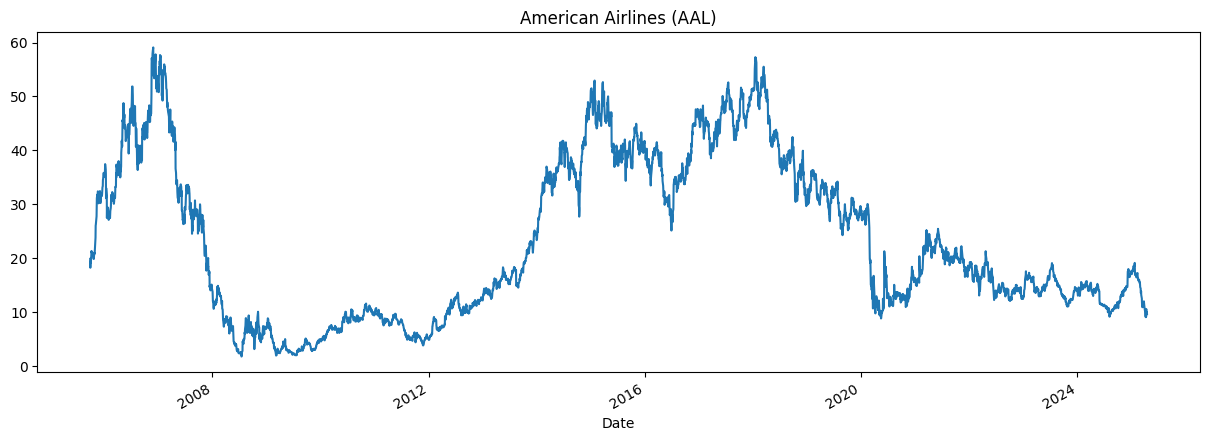

In [5]:
hist['Open'].plot(figsize=(15, 5), title="American Airlines (AAL)")
plt.show()

In [ ]:
aal.earnings_dates

In [ ]:
aal.earnings_dates

In [ ]:
aal.calendar

In [ ]:
## Pull a Bunch of Stocks

In [8]:
stonks = ["AAPL","CLX", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "NVDA", "JPM", "BRK-B", "JNJ"]

In [9]:
hists = {}
for s in stonks:
    tkr = yf.Ticker(s)
    history = tkr.history(period="3y")
    hists[s] = history

In [ ]:
## Plot the Stock Prices

In [10]:
for stock in stonks:
    temp_df = hists[stock].copy()

    fig = go.Figure(
        data=[
            go.Candlestick(
                x=temp_df.index,
                open=temp_df["Open"],
                high=temp_df["High"],
                low=temp_df["Low"],
                close=temp_df["Close"],
            )
        ]
    )

    fig.update_layout(
        margin=dict(l=20, r=20, t=60, b=20),
        height=300,
        paper_bgcolor="LightSteelBlue",
        title=stock,
    )

    fig.show()

In [ ]:
## Pull Tweets about each Stock

In [73]:
hists["CLX"].index.min()

Timestamp('2019-11-04 00:00:00-0500', tz='America/New_York')

In [79]:
stock = "CLX"

In [ ]:
# importing libraries and packages
import snscrape.modules.twitter as sntwitter
import pandas
from tqdm.notebook import tqdm

# creating list to append tweet data
tweets_list = []
# using TwitterSearchScraper to scrape data and append tweets to list
for i, tweet in tqdm(
    enumerate(
        sntwitter.TwitterSearchScraper(
            f"${stock} since:2019-11-04 until:2022-11-02"
        ).get_items()
    ),
    total=12_000,
):  # declare a username
    if i > 12_000:  # number of tweets you want to scrape
        break
    tweets_list.append(
        [tweet.date, tweet.id, tweet.content, tweet.user.username]
    )  # declare the attributes to be returned
# creating a dataframe from the tweets list above
tweet_df = pd.DataFrame(
    tweets_list, columns=["Datetime", "Tweet Id", "Text", "Username"]
)

  0%|          | 0/12000 [00:00<?, ?it/s]

In [96]:
tweet_df.to_parquet("clx_tweets.parquet")

In [ ]:
## Sentiment Analysis

In [97]:
from transformers import pipeline

model = f"cardiffnlp/twitter-roberta-base-sentiment-latest"

sentiment_task = pipeline("sentiment-analysis", model=model)
sentiment_task("Covid cases are increasing fast!")

Downloading:   0%|          | 0.00/929 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

[{'label': 'Negative', 'score': 0.7235767245292664}]

In [116]:
sent_results = {}
count = 0
for i, d in tqdm(tweet_df.iterrows(), total=len(tweet_df)):
    sent = sentiment_task(d["Text"])
    sent_results[d["Tweet Id"]] = sent
    count += 1
    if count == 500:
        break

  0%|          | 0/12001 [00:00<?, ?it/s]

In [166]:
sent_df = pd.DataFrame(sent_results).T
sent_df["label"] = sent_df[0].apply(lambda x: x["label"])
sent_df["score"] = sent_df[0].apply(lambda x: x["score"])
sent_df = sent_df.merge(
    tweet_df.set_index("Tweet Id"), left_index=True, right_index=True
)

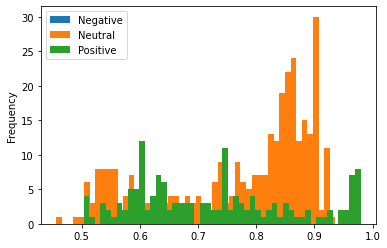

In [173]:
sent_df.groupby("label")["score"].plot(kind="hist", bins=50)
plt.legend()
plt.show()

In [174]:
sent_df["score_"] = sent_df["score"]

sent_df.loc[sent_df["label"] == "Negative", "score_"] = (
    sent_df.loc[sent_df["label"] == "Negative"]["score"] * -1
)

sent_df.loc[sent_df["label"] == "Neutral", "score_"] = 0

<AxesSubplot:ylabel='Frequency'>

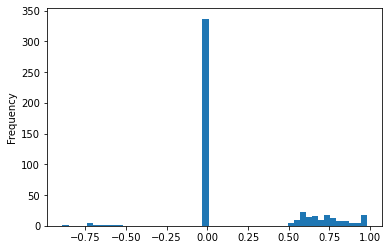

In [176]:
sent_df["score_"].plot(kind="hist", bins=50)

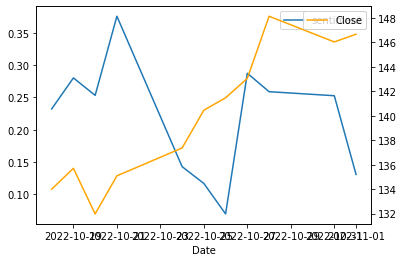

In [231]:
sent_df["Date"] = sent_df["Datetime"].dt.date

sent_daily = sent_df.groupby("Date")["score_"].mean()

clx_df = hists["CLX"].copy()
clx_df = clx_df.reset_index()
clx_df["Date"] = clx_df["Date"].dt.date
clx_df = clx_df.set_index("Date")

sent_and_stock = sent_daily.to_frame("sentiment").merge(
    clx_df, left_index=True, right_index=True
)

ax = sent_and_stock["sentiment"].plot(legend="Sentiment")
ax2 = ax.twinx()
sent_and_stock["Close"].plot(ax=ax2, color="orange", legend="Closing Price")
plt.show()